# 二、模型调优-机器学习模型的集成

In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [2]:
def reduce_mem_usage(df):
    '''
    遍历DataFrame的所有列并修改它们的数据类型以减少内存使用
    :param df: 需要处理的数据集
    :return:
    '''
    start_mem = df.memory_usage().sum() / 1024 ** 2  # 记录原数据的内存大小
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:  # 这里只过滤了object格式，如果代码中还包含其他类型，要一并过滤
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':  # 如果是int类型的话,不管是int64还是int32,都加入判断
                # 依次尝试转化成in8,in16,in32,in64类型,如果数据大小没溢出,那么转化
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:  # 不是整形的话,那就是浮点型
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:  # 如果不是数值型的话,转化成category类型
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2    # 看一下转化后的数据的内存大小
    print('Memory usage after optimization is {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))  # 看一下压缩比例
    return df

In [3]:
train_data = reduce_mem_usage(pd.read_csv('./data/train_final.csv'))
test_data = reduce_mem_usage(pd.read_csv('./data/test_final.csv'))

Memory usage of dataframe is 55.69 MB
Memory usage after optimization is 8.11 MB
Decreased by 85.4%
Memory usage of dataframe is 55.69 MB
Memory usage after optimization is 8.11 MB
Decreased by 85.4%


In [4]:
model_list = []
X_train = train_data.drop(columns = ['loan_status']).values
Y_train = train_data['loan_status'].values.astype(int)
X_test = test_data.drop(columns = ['loan_status']).values
Y_test = test_data['loan_status'].values.astype(int)

from sklearn.model_selection import KFold
kf = KFold(n_splits = 5)

five_fold_data = []
for train_idx, eval_idx in kf.split(X_train):
    x_train, x_eval = X_train[train_idx], X_train[eval_idx]
    y_train, y_eval = Y_train[train_idx], Y_train[eval_idx]
    
    five_fold_data.append([(x_train, y_train), (x_eval, y_eval)])

In [5]:
conti_cols, disc_cols = [], []
for col in train_data.columns:
    if 'continuous' in col:
        conti_cols.append(col)
    elif 'discrete' in col:
        disc_cols.append(disc_cols)

In [41]:
import lightgbm as lgb

num_round = 10

params = {'num_thread': 4, 'metric': 'binary_error', 'objective': 'binary',
                'num_leaves': 11, 'num_round': 1000, 'learning_rate': 0.03, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}
for idx, [(x_train, y_train), (x_eval, y_eval)] in enumerate(five_fold_data):
    print('{}-th model is training.'.format(idx+1))
    df_train = lgb.Dataset(x_train, label=y_train)
    df_valid = lgb.Dataset(x_eval, label=y_eval)
    bst = lgb.train(params, df_train, num_round, valid_sets=[df_valid])
    model_list.append(bst)

1-th model is training.
[LightGBM] [Info] Number of positive: 31731, number of negative: 8269
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2536
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 141
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.793275 -> initscore=1.344781
[LightGBM] [Info] Start training from score 1.344781
[1]	valid_0's binary_error: 0.1943
[2]	valid_0's binary_error: 0.1943
[3]	valid_0's binary_error: 0.1943
[4]	valid_0's binary_error: 0.1943
[5]	valid_0's binary_error: 0.1943
[6]	valid_0's binary_error: 0.1943
[7]	valid_0's binary_error: 0.1943
[8]	valid_0's binary_error: 0.1943
[9]	valid_0's binary_error: 0.1943
[10]	valid_0's binary_error: 0.1943
[11]	valid_0's binary_error: 0.1943
[12]	valid_0's binary_error: 0

[275]	valid_0's binary_error: 0.0717
[276]	valid_0's binary_error: 0.0718
[277]	valid_0's binary_error: 0.0718
[278]	valid_0's binary_error: 0.0716
[279]	valid_0's binary_error: 0.0716
[280]	valid_0's binary_error: 0.0714
[281]	valid_0's binary_error: 0.0715
[282]	valid_0's binary_error: 0.0717
[283]	valid_0's binary_error: 0.0718
[284]	valid_0's binary_error: 0.0719
[285]	valid_0's binary_error: 0.072
[286]	valid_0's binary_error: 0.0721
[287]	valid_0's binary_error: 0.0721
[288]	valid_0's binary_error: 0.0721
[289]	valid_0's binary_error: 0.0721
[290]	valid_0's binary_error: 0.072
[291]	valid_0's binary_error: 0.072
[292]	valid_0's binary_error: 0.0721
[293]	valid_0's binary_error: 0.072
[294]	valid_0's binary_error: 0.072
[295]	valid_0's binary_error: 0.072
[296]	valid_0's binary_error: 0.072
[297]	valid_0's binary_error: 0.0719
[298]	valid_0's binary_error: 0.0719
[299]	valid_0's binary_error: 0.0719
[300]	valid_0's binary_error: 0.0718
[301]	valid_0's binary_error: 0.0719
[302]	va

[511]	valid_0's binary_error: 0.0725
[512]	valid_0's binary_error: 0.0725
[513]	valid_0's binary_error: 0.0728
[514]	valid_0's binary_error: 0.0729
[515]	valid_0's binary_error: 0.0729
[516]	valid_0's binary_error: 0.0729
[517]	valid_0's binary_error: 0.0729
[518]	valid_0's binary_error: 0.0729
[519]	valid_0's binary_error: 0.0729
[520]	valid_0's binary_error: 0.0729
[521]	valid_0's binary_error: 0.0729
[522]	valid_0's binary_error: 0.0728
[523]	valid_0's binary_error: 0.0727
[524]	valid_0's binary_error: 0.0728
[525]	valid_0's binary_error: 0.0728
[526]	valid_0's binary_error: 0.0728
[527]	valid_0's binary_error: 0.0728
[528]	valid_0's binary_error: 0.0728
[529]	valid_0's binary_error: 0.073
[530]	valid_0's binary_error: 0.073
[531]	valid_0's binary_error: 0.0731
[532]	valid_0's binary_error: 0.0731
[533]	valid_0's binary_error: 0.0731
[534]	valid_0's binary_error: 0.0731
[535]	valid_0's binary_error: 0.0731
[536]	valid_0's binary_error: 0.0731
[537]	valid_0's binary_error: 0.073
[538

[752]	valid_0's binary_error: 0.0728
[753]	valid_0's binary_error: 0.0728
[754]	valid_0's binary_error: 0.0729
[755]	valid_0's binary_error: 0.0729
[756]	valid_0's binary_error: 0.0729
[757]	valid_0's binary_error: 0.0729
[758]	valid_0's binary_error: 0.0728
[759]	valid_0's binary_error: 0.0728
[760]	valid_0's binary_error: 0.0728
[761]	valid_0's binary_error: 0.0728
[762]	valid_0's binary_error: 0.0728
[763]	valid_0's binary_error: 0.0727
[764]	valid_0's binary_error: 0.0727
[765]	valid_0's binary_error: 0.0727
[766]	valid_0's binary_error: 0.0727
[767]	valid_0's binary_error: 0.0728
[768]	valid_0's binary_error: 0.0728
[769]	valid_0's binary_error: 0.0728
[770]	valid_0's binary_error: 0.0729
[771]	valid_0's binary_error: 0.0729
[772]	valid_0's binary_error: 0.0728
[773]	valid_0's binary_error: 0.0728
[774]	valid_0's binary_error: 0.0728
[775]	valid_0's binary_error: 0.0728
[776]	valid_0's binary_error: 0.0728
[777]	valid_0's binary_error: 0.0728
[778]	valid_0's binary_error: 0.0728
[

2-th model is training.
[LightGBM] [Info] Number of positive: 31901, number of negative: 8099
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 140
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797525 -> initscore=1.370897
[LightGBM] [Info] Start training from score 1.370897
[1]	valid_0's binary_error: 0.2113
[2]	valid_0's binary_error: 0.2113
[3]	valid_0's binary_error: 0.2113
[4]	valid_0's binary_error: 0.2113
[5]	valid_0's binary_error: 0.2113
[6]	valid_0's binary_error: 0.2113
[7]	valid_0's binary_error: 0.2113
[8]	valid_0's binary_error: 0.2113
[9]	valid_0's binary_error: 0.2113
[10]	valid_0's binary_error: 0.2113
[11]	valid_0's binary_error: 0.2113
[12]	valid_0's binary_error: 0

[222]	valid_0's binary_error: 0.081
[223]	valid_0's binary_error: 0.081
[224]	valid_0's binary_error: 0.081
[225]	valid_0's binary_error: 0.081
[226]	valid_0's binary_error: 0.0809
[227]	valid_0's binary_error: 0.0808
[228]	valid_0's binary_error: 0.0809
[229]	valid_0's binary_error: 0.0809
[230]	valid_0's binary_error: 0.081
[231]	valid_0's binary_error: 0.0809
[232]	valid_0's binary_error: 0.0808
[233]	valid_0's binary_error: 0.0811
[234]	valid_0's binary_error: 0.0812
[235]	valid_0's binary_error: 0.081
[236]	valid_0's binary_error: 0.0811
[237]	valid_0's binary_error: 0.0813
[238]	valid_0's binary_error: 0.0813
[239]	valid_0's binary_error: 0.0812
[240]	valid_0's binary_error: 0.0805
[241]	valid_0's binary_error: 0.0806
[242]	valid_0's binary_error: 0.0807
[243]	valid_0's binary_error: 0.0809
[244]	valid_0's binary_error: 0.0808
[245]	valid_0's binary_error: 0.0812
[246]	valid_0's binary_error: 0.0809
[247]	valid_0's binary_error: 0.0811
[248]	valid_0's binary_error: 0.081
[249]	va

[457]	valid_0's binary_error: 0.0816
[458]	valid_0's binary_error: 0.0816
[459]	valid_0's binary_error: 0.0816
[460]	valid_0's binary_error: 0.0816
[461]	valid_0's binary_error: 0.0817
[462]	valid_0's binary_error: 0.0817
[463]	valid_0's binary_error: 0.0817
[464]	valid_0's binary_error: 0.0817
[465]	valid_0's binary_error: 0.0816
[466]	valid_0's binary_error: 0.0816
[467]	valid_0's binary_error: 0.0815
[468]	valid_0's binary_error: 0.0815
[469]	valid_0's binary_error: 0.0815
[470]	valid_0's binary_error: 0.0816
[471]	valid_0's binary_error: 0.0815
[472]	valid_0's binary_error: 0.0815
[473]	valid_0's binary_error: 0.0815
[474]	valid_0's binary_error: 0.0815
[475]	valid_0's binary_error: 0.0816
[476]	valid_0's binary_error: 0.0816
[477]	valid_0's binary_error: 0.0816
[478]	valid_0's binary_error: 0.0815
[479]	valid_0's binary_error: 0.0814
[480]	valid_0's binary_error: 0.0814
[481]	valid_0's binary_error: 0.0814
[482]	valid_0's binary_error: 0.0814
[483]	valid_0's binary_error: 0.0815
[

[683]	valid_0's binary_error: 0.0822
[684]	valid_0's binary_error: 0.0822
[685]	valid_0's binary_error: 0.0823
[686]	valid_0's binary_error: 0.0823
[687]	valid_0's binary_error: 0.0823
[688]	valid_0's binary_error: 0.0823
[689]	valid_0's binary_error: 0.0823
[690]	valid_0's binary_error: 0.0823
[691]	valid_0's binary_error: 0.0823
[692]	valid_0's binary_error: 0.0823
[693]	valid_0's binary_error: 0.0822
[694]	valid_0's binary_error: 0.0822
[695]	valid_0's binary_error: 0.0822
[696]	valid_0's binary_error: 0.0822
[697]	valid_0's binary_error: 0.0822
[698]	valid_0's binary_error: 0.0822
[699]	valid_0's binary_error: 0.0822
[700]	valid_0's binary_error: 0.0822
[701]	valid_0's binary_error: 0.0821
[702]	valid_0's binary_error: 0.0821
[703]	valid_0's binary_error: 0.0821
[704]	valid_0's binary_error: 0.0821
[705]	valid_0's binary_error: 0.0821
[706]	valid_0's binary_error: 0.0821
[707]	valid_0's binary_error: 0.0821
[708]	valid_0's binary_error: 0.0821
[709]	valid_0's binary_error: 0.0821
[

[929]	valid_0's binary_error: 0.0817
[930]	valid_0's binary_error: 0.0816
[931]	valid_0's binary_error: 0.0816
[932]	valid_0's binary_error: 0.0816
[933]	valid_0's binary_error: 0.0818
[934]	valid_0's binary_error: 0.0817
[935]	valid_0's binary_error: 0.0817
[936]	valid_0's binary_error: 0.0817
[937]	valid_0's binary_error: 0.0816
[938]	valid_0's binary_error: 0.0816
[939]	valid_0's binary_error: 0.0816
[940]	valid_0's binary_error: 0.0816
[941]	valid_0's binary_error: 0.0817
[942]	valid_0's binary_error: 0.0817
[943]	valid_0's binary_error: 0.0816
[944]	valid_0's binary_error: 0.0816
[945]	valid_0's binary_error: 0.0816
[946]	valid_0's binary_error: 0.0815
[947]	valid_0's binary_error: 0.0815
[948]	valid_0's binary_error: 0.0815
[949]	valid_0's binary_error: 0.0814
[950]	valid_0's binary_error: 0.0814
[951]	valid_0's binary_error: 0.0814
[952]	valid_0's binary_error: 0.0814
[953]	valid_0's binary_error: 0.0815
[954]	valid_0's binary_error: 0.0815
[955]	valid_0's binary_error: 0.0815
[

[154]	valid_0's binary_error: 0.0843
[155]	valid_0's binary_error: 0.0843
[156]	valid_0's binary_error: 0.0842
[157]	valid_0's binary_error: 0.0842
[158]	valid_0's binary_error: 0.0844
[159]	valid_0's binary_error: 0.0844
[160]	valid_0's binary_error: 0.0845
[161]	valid_0's binary_error: 0.0845
[162]	valid_0's binary_error: 0.0845
[163]	valid_0's binary_error: 0.0845
[164]	valid_0's binary_error: 0.0844
[165]	valid_0's binary_error: 0.0846
[166]	valid_0's binary_error: 0.0845
[167]	valid_0's binary_error: 0.0846
[168]	valid_0's binary_error: 0.0846
[169]	valid_0's binary_error: 0.0844
[170]	valid_0's binary_error: 0.0843
[171]	valid_0's binary_error: 0.0843
[172]	valid_0's binary_error: 0.0843
[173]	valid_0's binary_error: 0.0844
[174]	valid_0's binary_error: 0.0843
[175]	valid_0's binary_error: 0.0844
[176]	valid_0's binary_error: 0.0844
[177]	valid_0's binary_error: 0.0846
[178]	valid_0's binary_error: 0.0844
[179]	valid_0's binary_error: 0.0843
[180]	valid_0's binary_error: 0.0842
[

[579]	valid_0's binary_error: 0.0842
[580]	valid_0's binary_error: 0.0843
[581]	valid_0's binary_error: 0.0841
[582]	valid_0's binary_error: 0.0841
[583]	valid_0's binary_error: 0.0842
[584]	valid_0's binary_error: 0.084
[585]	valid_0's binary_error: 0.084
[586]	valid_0's binary_error: 0.0841
[587]	valid_0's binary_error: 0.0841
[588]	valid_0's binary_error: 0.0841
[589]	valid_0's binary_error: 0.0841
[590]	valid_0's binary_error: 0.0841
[591]	valid_0's binary_error: 0.084
[592]	valid_0's binary_error: 0.084
[593]	valid_0's binary_error: 0.084
[594]	valid_0's binary_error: 0.084
[595]	valid_0's binary_error: 0.084
[596]	valid_0's binary_error: 0.0841
[597]	valid_0's binary_error: 0.0839
[598]	valid_0's binary_error: 0.084
[599]	valid_0's binary_error: 0.084
[600]	valid_0's binary_error: 0.084
[601]	valid_0's binary_error: 0.084
[602]	valid_0's binary_error: 0.084
[603]	valid_0's binary_error: 0.084
[604]	valid_0's binary_error: 0.084
[605]	valid_0's binary_error: 0.084
[606]	valid_0's 

[984]	valid_0's binary_error: 0.0841
[985]	valid_0's binary_error: 0.084
[986]	valid_0's binary_error: 0.084
[987]	valid_0's binary_error: 0.084
[988]	valid_0's binary_error: 0.0842
[989]	valid_0's binary_error: 0.0842
[990]	valid_0's binary_error: 0.0842
[991]	valid_0's binary_error: 0.0842
[992]	valid_0's binary_error: 0.0842
[993]	valid_0's binary_error: 0.0841
[994]	valid_0's binary_error: 0.084
[995]	valid_0's binary_error: 0.0841
[996]	valid_0's binary_error: 0.0841
[997]	valid_0's binary_error: 0.0841
[998]	valid_0's binary_error: 0.0841
[999]	valid_0's binary_error: 0.0842
[1000]	valid_0's binary_error: 0.0842
4-th model is training.
[LightGBM] [Info] Number of positive: 31898, number of negative: 8102
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2596
[LightGBM] [Info]

[251]	valid_0's binary_error: 0.0842
[252]	valid_0's binary_error: 0.0842
[253]	valid_0's binary_error: 0.0842
[254]	valid_0's binary_error: 0.0842
[255]	valid_0's binary_error: 0.0842
[256]	valid_0's binary_error: 0.0842
[257]	valid_0's binary_error: 0.0843
[258]	valid_0's binary_error: 0.0844
[259]	valid_0's binary_error: 0.0844
[260]	valid_0's binary_error: 0.0843
[261]	valid_0's binary_error: 0.0843
[262]	valid_0's binary_error: 0.0843
[263]	valid_0's binary_error: 0.0843
[264]	valid_0's binary_error: 0.0843
[265]	valid_0's binary_error: 0.0843
[266]	valid_0's binary_error: 0.0843
[267]	valid_0's binary_error: 0.0843
[268]	valid_0's binary_error: 0.0844
[269]	valid_0's binary_error: 0.0844
[270]	valid_0's binary_error: 0.0844
[271]	valid_0's binary_error: 0.0844
[272]	valid_0's binary_error: 0.0844
[273]	valid_0's binary_error: 0.0841
[274]	valid_0's binary_error: 0.0841
[275]	valid_0's binary_error: 0.0841
[276]	valid_0's binary_error: 0.0841
[277]	valid_0's binary_error: 0.0841
[

[713]	valid_0's binary_error: 0.084
[714]	valid_0's binary_error: 0.084
[715]	valid_0's binary_error: 0.084
[716]	valid_0's binary_error: 0.084
[717]	valid_0's binary_error: 0.0841
[718]	valid_0's binary_error: 0.0841
[719]	valid_0's binary_error: 0.0841
[720]	valid_0's binary_error: 0.0841
[721]	valid_0's binary_error: 0.084
[722]	valid_0's binary_error: 0.084
[723]	valid_0's binary_error: 0.0839
[724]	valid_0's binary_error: 0.0839
[725]	valid_0's binary_error: 0.0839
[726]	valid_0's binary_error: 0.0838
[727]	valid_0's binary_error: 0.0838
[728]	valid_0's binary_error: 0.0838
[729]	valid_0's binary_error: 0.0839
[730]	valid_0's binary_error: 0.0838
[731]	valid_0's binary_error: 0.0838
[732]	valid_0's binary_error: 0.0838
[733]	valid_0's binary_error: 0.0838
[734]	valid_0's binary_error: 0.0838
[735]	valid_0's binary_error: 0.0838
[736]	valid_0's binary_error: 0.0839
[737]	valid_0's binary_error: 0.0839
[738]	valid_0's binary_error: 0.0839
[739]	valid_0's binary_error: 0.0839
[740]	v

[947]	valid_0's binary_error: 0.0841
[948]	valid_0's binary_error: 0.0841
[949]	valid_0's binary_error: 0.0841
[950]	valid_0's binary_error: 0.084
[951]	valid_0's binary_error: 0.084
[952]	valid_0's binary_error: 0.084
[953]	valid_0's binary_error: 0.0839
[954]	valid_0's binary_error: 0.0839
[955]	valid_0's binary_error: 0.0839
[956]	valid_0's binary_error: 0.0839
[957]	valid_0's binary_error: 0.0839
[958]	valid_0's binary_error: 0.0838
[959]	valid_0's binary_error: 0.0837
[960]	valid_0's binary_error: 0.0835
[961]	valid_0's binary_error: 0.0836
[962]	valid_0's binary_error: 0.0836
[963]	valid_0's binary_error: 0.0836
[964]	valid_0's binary_error: 0.0835
[965]	valid_0's binary_error: 0.0836
[966]	valid_0's binary_error: 0.0835
[967]	valid_0's binary_error: 0.0835
[968]	valid_0's binary_error: 0.0836
[969]	valid_0's binary_error: 0.0835
[970]	valid_0's binary_error: 0.0837
[971]	valid_0's binary_error: 0.0836
[972]	valid_0's binary_error: 0.0835
[973]	valid_0's binary_error: 0.0835
[974

[213]	valid_0's binary_error: 0.0798
[214]	valid_0's binary_error: 0.08
[215]	valid_0's binary_error: 0.0801
[216]	valid_0's binary_error: 0.0802
[217]	valid_0's binary_error: 0.0802
[218]	valid_0's binary_error: 0.08
[219]	valid_0's binary_error: 0.0801
[220]	valid_0's binary_error: 0.0802
[221]	valid_0's binary_error: 0.0802
[222]	valid_0's binary_error: 0.0803
[223]	valid_0's binary_error: 0.0803
[224]	valid_0's binary_error: 0.0804
[225]	valid_0's binary_error: 0.0802
[226]	valid_0's binary_error: 0.0801
[227]	valid_0's binary_error: 0.08
[228]	valid_0's binary_error: 0.0801
[229]	valid_0's binary_error: 0.0801
[230]	valid_0's binary_error: 0.0801
[231]	valid_0's binary_error: 0.08
[232]	valid_0's binary_error: 0.08
[233]	valid_0's binary_error: 0.08
[234]	valid_0's binary_error: 0.0798
[235]	valid_0's binary_error: 0.08
[236]	valid_0's binary_error: 0.08
[237]	valid_0's binary_error: 0.08
[238]	valid_0's binary_error: 0.08
[239]	valid_0's binary_error: 0.08
[240]	valid_0's binary_

[666]	valid_0's binary_error: 0.0804
[667]	valid_0's binary_error: 0.0804
[668]	valid_0's binary_error: 0.0804
[669]	valid_0's binary_error: 0.0804
[670]	valid_0's binary_error: 0.0803
[671]	valid_0's binary_error: 0.0802
[672]	valid_0's binary_error: 0.0802
[673]	valid_0's binary_error: 0.0802
[674]	valid_0's binary_error: 0.0803
[675]	valid_0's binary_error: 0.0802
[676]	valid_0's binary_error: 0.0802
[677]	valid_0's binary_error: 0.0802
[678]	valid_0's binary_error: 0.0802
[679]	valid_0's binary_error: 0.0802
[680]	valid_0's binary_error: 0.0802
[681]	valid_0's binary_error: 0.0802
[682]	valid_0's binary_error: 0.0802
[683]	valid_0's binary_error: 0.0802
[684]	valid_0's binary_error: 0.0802
[685]	valid_0's binary_error: 0.0801
[686]	valid_0's binary_error: 0.0803
[687]	valid_0's binary_error: 0.0803
[688]	valid_0's binary_error: 0.0803
[689]	valid_0's binary_error: 0.0802
[690]	valid_0's binary_error: 0.0803
[691]	valid_0's binary_error: 0.0802
[692]	valid_0's binary_error: 0.0802
[

[900]	valid_0's binary_error: 0.0805
[901]	valid_0's binary_error: 0.0804
[902]	valid_0's binary_error: 0.0805
[903]	valid_0's binary_error: 0.0806
[904]	valid_0's binary_error: 0.0804
[905]	valid_0's binary_error: 0.0805
[906]	valid_0's binary_error: 0.0805
[907]	valid_0's binary_error: 0.0805
[908]	valid_0's binary_error: 0.0805
[909]	valid_0's binary_error: 0.0805
[910]	valid_0's binary_error: 0.0805
[911]	valid_0's binary_error: 0.0805
[912]	valid_0's binary_error: 0.0805
[913]	valid_0's binary_error: 0.0805
[914]	valid_0's binary_error: 0.0804
[915]	valid_0's binary_error: 0.0804
[916]	valid_0's binary_error: 0.0804
[917]	valid_0's binary_error: 0.0803
[918]	valid_0's binary_error: 0.0803
[919]	valid_0's binary_error: 0.0803
[920]	valid_0's binary_error: 0.0803
[921]	valid_0's binary_error: 0.0803
[922]	valid_0's binary_error: 0.0803
[923]	valid_0's binary_error: 0.0802
[924]	valid_0's binary_error: 0.0802
[925]	valid_0's binary_error: 0.0802
[926]	valid_0's binary_error: 0.0802
[

In [42]:
five_fold_pred = np.zeros((5, len(X_test)))
for i, bst in enumerate(model_list):
    ypred = bst.predict(X_test, num_iteration = bst.best_iteration)
    five_fold_pred[i] = ypred
y_pred_mean = (five_fold_pred.mean(axis = -2)>0.5).astype(int)
baseline_acc = accuracy_score(y_pred_mean, Y_test)

In [44]:
baseline_acc # baseline

0.91768

## 1 基分类器的训练

In [6]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingClassifier as GBDT
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [7]:
# 缺失值处理
# 参考第一节，删除部分列
## 1 continuous_funded_amnt 与 continuous_loan_amnt完全相同，二者删其一
## 2 discrete_policy_code_1_one_hot 和 discrete_pymnt_plan_1_one_hot 取值唯一，信息熵为零
## 3 删除所有严重缺失列（缺失比例大于等于0.7）
del train_data['continuous_funded_amnt']; del test_data['continuous_funded_amnt']
del train_data['discrete_policy_code_1_one_hot']; del test_data['discrete_policy_code_1_one_hot']
del train_data['discrete_pymnt_plan_1_one_hot']; del test_data['discrete_pymnt_plan_1_one_hot']

deleted_cols = []
for col in train_data.columns:
    if len(train_data[train_data[col].isna()]) / len(train_data) >= 0.7:
        print(col)
        deleted_cols.append(col)

train_data.drop(columns = deleted_cols, inplace=True)
test_data.drop(columns = deleted_cols, inplace=True)

continuous_annual_inc_joint
continuous_dti_joint
continuous_mths_since_last_record


In [8]:
# 4 其他的缺失值用插值法填充
train_data_dropna, test_data_dropna = train_data.copy(), test_data.copy()
for row in train_data_dropna:
    train_data_dropna[row] = train_data_dropna[row].interpolate()
    train_data_dropna.dropna(inplace=True)
    
for row in test_data_dropna:
    test_data_dropna[row] = test_data_dropna[row].interpolate()
    test_data_dropna.dropna(inplace=True)

In [9]:
X_train = train_data_dropna.drop(columns = ['loan_status']).values
Y_train = train_data_dropna['loan_status'].values.astype(int)
X_test = test_data_dropna.drop(columns = ['loan_status']).values
Y_test = test_data_dropna['loan_status'].values.astype(int)

### a) Random Forest

In [ ]:
# Random Forest
rf1 = RF(
    n_estimators=100,
    min_impurity_decrease=
)


In [116]:

# 五折交叉验证找最优参数
params_rf = {
    'n_estimators': range(10, 71, 10),
    'max_depth': range(3, 14, 2),
    'min_samples_split': range(50, 201, 20),
    'criterion': ['gini', 'entropy']
}
gs_rf = GridSearchCV(estimator = RF(min_samples_leaf = 20, 
                                   max_features = 'sqrt', random_state = 10), 
                     scoring = 'accuracy', cv=5, param_grid = params_rf)
gs_rf.fit(X_train, Y_train)
print(gs_rf.grid_scores_, gs_rf.best_params_, gs_rf.best_score_)


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [117]:
bst_idx = 0
for idx in range(len(gs_rf.cv_results_['rank_test_score'])):
    if gs_rf.cv_results_['rank_test_score'][idx] == 1:
        print(idx)
        bst_idx = idx
        break

293


In [123]:
gs_rf.cv_results_['mean_test_score'][bst_idx]

0.902797548651751

In [193]:
gs_rf.cv_results_['params'][bst_idx]

{'criterion': 'gini',
 'max_depth': 13,
 'min_samples_split': 70,
 'n_estimators': 70}

In [10]:
rf_bst = RF(criterion = 'gini', 
               max_depth = 13, 
               min_samples_split = 70, 
               n_estimators = 70,
           max_features = 'sqrt', random_state = 10)

### b) Xgboost

In [18]:
# Xgboost
# 五折交叉验证找最优参数
from xgboost.sklearn import XGBClassifier
xgb1 = XGBClassifier(max_depth = 3,
                     learning_rate = 0.1,
                     n_estimators = 5000,
                     silent=False,
                     objective='binary:logistic',
                     booster='gbtree',
                     n_jobs=4,
                     gamma = 0,
                     min_child_weight=1,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     seed=7)

dtrain = xgb.DMatrix(train_data_dropna.drop(columns=['loan_status']), label=train_data_dropna['loan_status'])
dtest = xgb.DMatrix(test_data_dropna.drop(columns=['loan_status']), label=train_data_dropna['loan_status'])


In [19]:
cv_result = xgb.cv(xgb1.get_xgb_params(), 
                  dtrain, 
                  num_boost_round = 5000,
                  nfold=5,
                  metrics='error',
                  early_stopping_rounds=50,
                  callbacks=[xgb.callback.early_stop(50), 
                            xgb.callback.print_evaluation(period=1,show_stdv=True)])

[18:00:37] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:00:37] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:00:37] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:00:38] WARNI

/home/jyy/anaconda3/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[4]	train-error:0.09939+0.00208	test-error:0.10094+0.00665
[5]	train-error:0.09976+0.00160	test-error:0.10129+0.00712
[6]	train-error:0.09919+0.00131	test-error:0.10122+0.00705
[7]	train-error:0.09893+0.00171	test-error:0.10108+0.00659
[8]	train-error:0.09909+0.00159	test-error:0.10136+0.00659
[9]	train-error:0.09858+0.00127	test-error:0.10044+0.00659
[10]	train-error:0.09844+0.00111	test-error:0.10044+0.00637
[11]	train-error:0.09826+0.00135	test-error:0.10002+0.00676
[12]	train-error:0.09784+0.00119	test-error:0.10051+0.00615
[13]	train-error:0.09801+0.00128	test-error:0.10058+0.00598
[14]	train-error:0.09780+0.00131	test-error:0.09946+0.00503
[15]	train-error:0.09736+0.00107	test-error:0.09939+0.00509
[16]	train-error:0.09724+0.00121	test-error:0.09953+0.00519
[17]	train-error:0.09699+0.00142	test-error:0.09967+0.00525
[18]	train-error:0.09703+0.00132	test-error:0.09903+0.00595
[19]	train-error:0.09674+0.00110	test-error:0.09903+0.00579
[20]	train-error:0.09648+0.00169	test-error:0.

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

1 如上，最佳迭代次数为79（即决策树数量）时最佳，故将n_estimator参数固定为202，训练模型，初步得到accuracy

2 确定max_depth, min_weight参数
- 这两个参数对最终结果有很大影响，故优先调整
- 先大值范围粗调，再小范围细调

In [21]:
xgb1 = XGBClassifier(max_depth = 3,
                     learning_rate = 0.1,
                     n_estimators = 79,
                     silent=False,
                     objective='binary:logistic',
                     booster='gbtree',
                     n_jobs=4,
                     gamma = 0,
                     min_child_weight=1,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     seed=7)

In [22]:
params_xgb = {'max_depth':[1,2,3,4,5],
             'min_child_weight':[1,2,3,4,5]}
gs_xgb = GridSearchCV(xgb1,params_xgb,scoring='accuracy',iid=False,cv=5)

gs_xgb.fit(train_data_dropna.drop(columns='loan_status'), train_data_dropna['loan_status'])


/home/jyy/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:01:40] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:01:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jyy/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[18:01:41] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:01:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:01:41] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:01:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:01:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:01:44] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:01:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:01:44] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bin

[18:01:47] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:01:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:01:47] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:01:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:01:52] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:01:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:01:52] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:01:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:01:57] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:01:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:01:58] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:01:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:02:04] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:02:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:02:04] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:02:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:02:12] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:02:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:02:13] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:02:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:02:21] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:02:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:02:22] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:02:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:02:32] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:02:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:02:32] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:02:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


[18:02:35] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:02:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=79, n_jobs=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=7,
                                     silent=False, subsample=0.8,
       

In [23]:
print('best_params:',gs_xgb.best_params_)
print('best_score:',gs_xgb.best_score_)

best_params: {'max_depth': 3, 'min_child_weight': 5}
best_score: 0.9053347949414053


In [24]:
xgb1 = XGBClassifier(max_depth = 3,
                     learning_rate = 0.1,
                     n_estimators = 79,
                     silent=False,
                     objective='binary:logistic',
                     booster='gbtree',
                     n_jobs=4,
                     gamma = 0,
                     min_child_weight=5,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     seed=7)
params_xgb = {'min_child_weight':[5,6,7,8,9,10]}
gs_xgb = GridSearchCV(xgb1,params_xgb,scoring='accuracy',iid=False,cv=5)

gs_xgb.fit(train_data_dropna.drop(columns='loan_status'), train_data_dropna['loan_status'])


/home/jyy/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:10] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:04:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jyy/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[18:04:10] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:04:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:04:11] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:04:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:04:16] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:04:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:04:17] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:04:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


[18:04:22] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:04:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weight=5,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=79, n_jobs=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=7,
                                     silent=False, subsample=0.8,
       

In [25]:
print('best_params:',gs_xgb.best_params_)
print('best_score:',gs_xgb.best_score_)

best_params: {'min_child_weight': 5}
best_score: 0.9053347949414053


3 确定gamma参数
- 上一步骤中得到最优max_depth为3，min_child_weight为5
- 调整gamma值，gamma的含义是进一步分割叶子结点，所需满足的最小损失差值；gamma越小，训练集上拟合精度月高，但越容易过拟合；反之泛化能力越强，但容易欠拟合

In [26]:
params_xgb2 = {'gamma':list(range(1,10))}
gs_xgb = GridSearchCV(xgb1,params_xgb2,scoring='accuracy',iid=False,cv=5)

gs_xgb.fit(train_data.drop(columns='loan_status'), train_data['loan_status'])

/home/jyy/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:05:06] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:05:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jyy/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[18:05:08] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:05:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:05:09] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:05:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:05:30] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:05:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:05:32] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:05:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:05:52] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:05:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:05:53] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:05:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


[18:06:12] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:06:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weight=5,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=79, n_jobs=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=7,
                                     silent=False, subsample=0.8,
       

In [27]:
print('best_params:',gs_xgb.best_params_)
print('best_score:',gs_xgb.best_score_)

best_params: {'gamma': 7}
best_score: 0.9198599999999999


4 调整subsample与colsample_bytree参数
- gamma最优为2时，acc相比上一步有提升，故固定之
- 下面微调subsample与colsample_bytree参数

In [28]:
xgb1 = XGBClassifier(max_depth = 3,
                     learning_rate = 0.1,
                     n_estimators = 202,
                     silent=False,
                     objective='binary:logistic',
                     booster='gbtree',
                     n_jobs=4,
                     gamma = 7,
                     min_child_weight=5,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     seed=7)

In [29]:
params_xgb3 = {'subsample':[i/10.0 for i in range(5,11)],
             'colsample_bytree':[i/10.0 for i in range(5,11)]}

gs_xgb = GridSearchCV(xgb1,params_xgb3,scoring='accuracy',iid=False,cv=5)

gs_xgb.fit(train_data.drop(columns='loan_status'), train_data['loan_status'])

/home/jyy/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:07:13] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:07:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jyy/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[18:07:16] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:07:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:07:19] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:07:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:07:57] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:07:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:08:00] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:08:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:08:33] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:08:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:08:36] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:08:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:09:20] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:09:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:09:23] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:09:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:10:00] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:10:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:10:04] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:10:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:10:54] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:10:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:10:57] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:10:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:11:39] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:11:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:11:43] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:11:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:12:38] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:12:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:42] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:12:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:13:28] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:13:32] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:14:33] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:14:37] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:15:28] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:15:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:15:33] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:15:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:16:39] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:16:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:16:43] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:16:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


[18:17:33] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:17:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=7, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weight=5,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=202, n_jobs=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=7,
                                     silent=False, subsample=0.8,
      

In [30]:
print('best_params:',gs_xgb.best_params_)
print('best_score:',gs_xgb.best_score_)

best_params: {'colsample_bytree': 0.8, 'subsample': 0.9}
best_score: 0.9200799999999999


5 调整正则化参数
- colsample_bytree最优为0.6，subsample最优为0.8时，acc相比上一步又有提升，故固定之
- 下面调整正则化参数

In [31]:
xgb1 = XGBClassifier(max_depth = 3,
                     learning_rate = 0.1,
                     n_estimators = 202,
                     silent=False,
                     objective='binary:logistic',
                     booster='gbtree',
                     n_jobs=4,
                     gamma = 7,
                     min_child_weight=5,
                     subsample=0.9,
                     colsample_bytree=0.8,
                     seed=7)

In [32]:
params_xgb4 = {'reg_lambda':[i/10.0 for i in range(1,11)]}
gs_xgb = GridSearchCV(xgb1,params_xgb4,scoring='accuracy',iid=False,cv=5)
gs_xgb.fit(train_data.drop(columns='loan_status'), train_data['loan_status'])


/home/jyy/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:19:00] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:19:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jyy/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[18:19:03] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:19:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:06] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:19:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:19:52] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:19:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:55] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:19:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:20:40] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:20:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:20:44] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:20:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

[18:21:29] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:21:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:21:32] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:21:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


[18:21:42] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:21:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=7, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weight=5,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=202, n_jobs=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=7,
                                     silent=False, subsample=0.9,
      

In [33]:
print('best_params:',gs_xgb.best_params_)
print('best_score:',gs_xgb.best_score_)

best_params: {'reg_lambda': 0.2}
best_score: 0.92014


In [34]:
# 固定最佳模型，结束调参
from xgboost.sklearn import XGBClassifier
xgb_bst = XGBClassifier(max_depth = 3,
                     learning_rate = 0.1,
                     n_estimators = 202,
                     silent=False,
                     objective='binary:logistic',
                     booster='gbtree',
                     n_jobs=4,
                     gamma = 7,
                     min_child_weight=5,
                     subsample=0.9,
                     colsample_bytree=0.8,
                     reg_lambda = 0.2,
                     seed=7)

### c) GBDT

In [45]:
# GBDT baseline
gbdt1 = GBDT(n_estimators=100,
            learning_rate = 0.1,
            max_depth = 3,
             min_samples_leaf = 2,
             subsample=0.5,
            n_iter_no_change = 500,
            validation_fraction=0.7,
            random_state = 0)

gbdt1.fit(train_data_dropna.drop(columns='loan_status'), train_data_dropna['loan_status'])

GradientBoostingClassifier(min_samples_leaf=2, n_iter_no_change=500,
                           random_state=0, subsample=0.5,
                           validation_fraction=0.7)

In [46]:
gbdt1.score(X_train, Y_train)

0.9094946077394798

In [38]:
gbdt1.score(X_test, Y_test)

0.901916252661462

1 调整n_estimators参数
- 粗调 + 精调

In [47]:
gbdt1 = GBDT(n_estimators=100,
            learning_rate = 0.1,
            max_depth = 3,
             min_samples_leaf = 2,
             subsample=0.5,
            n_iter_no_change = 500,
            validation_fraction=0.7,
            random_state = 0)

In [40]:
params_gbdt = {'n_estimators':[i * 100 for i in range(1, 6)]}
gs_gbdt = GridSearchCV(gbdt1, params_gbdt,scoring='accuracy',iid=False,cv=5)
gs_gbdt.fit(train_data_dropna.drop(columns='loan_status'), train_data_dropna['loan_status'])


/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(min_samples_leaf=2,
                                                  n_iter_no_change=500,
                                                  random_state=0, subsample=0.5,
                                                  validation_fraction=0.7),
             iid=False, param_grid={'n_estimators': [100, 200, 300, 400, 500]},
             scoring='accuracy')

In [41]:
print('best_params:',gs_gbdt.best_params_)
print('best_score:',gs_gbdt.best_score_)

best_params: {'n_estimators': 100}
best_score: 0.8993440151943648


In [42]:
params_gbdt = {'n_estimators':[i * 10 for i in range(6, 16)]}
gs_gbdt = GridSearchCV(gbdt1, params_gbdt,scoring='accuracy',iid=False,cv=5)
gs_gbdt.fit(train_data_dropna.drop(columns='loan_status'), train_data_dropna['loan_status'])


/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(min_samples_leaf=2,
                                                  n_iter_no_change=500,
                                                  random_state=0, subsample=0.5,
                                                  validation_fraction=0.7),
             iid=False,
             param_grid={'n_estimators': [60, 70, 80, 90, 100, 110, 120, 130,
                                          140, 150]},
             scoring='accuracy')

In [43]:
print('best_params:',gs_gbdt.best_params_)
print('best_score:',gs_gbdt.best_score_)

best_params: {'n_estimators': 60}
best_score: 0.901176490168301


In [48]:
params_gbdt = {'n_estimators':[i * 10 for i in range(1, 7)]}
gs_gbdt = GridSearchCV(gbdt1, params_gbdt,scoring='accuracy',iid=False,cv=5)
gs_gbdt.fit(train_data_dropna.drop(columns='loan_status'), train_data_dropna['loan_status'])


/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(min_samples_leaf=2,
                                                  n_iter_no_change=500,
                                                  random_state=0, subsample=0.5,
                                                  validation_fraction=0.7),
             iid=False, param_grid={'n_estimators': [10, 20, 30, 40, 50, 60]},
             scoring='accuracy')

In [49]:
print('best_params:',gs_gbdt.best_params_)
print('best_score:',gs_gbdt.best_score_)

best_params: {'n_estimators': 50}
best_score: 0.9022338210245515


In [50]:
params_gbdt = {'n_estimators':[i for i in range(41, 61)]}
gs_gbdt = GridSearchCV(gbdt1, params_gbdt,scoring='accuracy',iid=False,cv=5)
gs_gbdt.fit(train_data_dropna.drop(columns='loan_status'), train_data_dropna['loan_status'])


/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(min_samples_leaf=2,
                                                  n_iter_no_change=500,
                                                  random_state=0, subsample=0.5,
                                                  validation_fraction=0.7),
             iid=False,
             param_grid={'n_estimators': [41, 42, 43, 44, 45, 46, 47, 48, 49,
                                          50, 51, 52, 53, 54, 55, 56, 57, 58,
                                          59, 60]},
             scoring='accuracy')

In [51]:
print('best_params:',gs_gbdt.best_params_)
print('best_score:',gs_gbdt.best_score_)

best_params: {'n_estimators': 51}
best_score: 0.9025862315227924


2 调整max_depth, min_samples_leaf参数
- 固定n_estimators为51
- 从默认值开始调

In [64]:
gbdt1 = GBDT(n_estimators=51,
            learning_rate = 0.1,
            max_depth = 1,
             min_samples_leaf = 3,
             subsample=0.5,
            n_iter_no_change = 500,
            validation_fraction=0.7,
            random_state = 0)

In [65]:
params_gbdt = {'max_depth':[1,2,3,4,5],
              'min_samples_leaf': [1,2,3,4,5]}
gs_gbdt = GridSearchCV(gbdt1, params_gbdt,scoring='accuracy',iid=False,cv=5)
gs_gbdt.fit(train_data_dropna.drop(columns='loan_status'), train_data_dropna['loan_status'])


/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=1,
                                                  min_samples_leaf=3,
                                                  n_estimators=51,
                                                  n_iter_no_change=500,
                                                  random_state=0, subsample=0.5,
                                                  validation_fraction=0.7),
             iid=False,
             param_grid={'max_depth': [1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4, 5]},
             scoring='accuracy')

In [66]:
print('best_params:',gs_gbdt.best_params_)
print('best_score:',gs_gbdt.best_score_)

best_params: {'max_depth': 3, 'min_samples_leaf': 2}
best_score: 0.9025862315227924


2 再调min_samples_split
- 固定max_depth为1，min_samples_leaf为3
- 调整min_samples_split

In [67]:
params_gbdt = {'min_samples_split':[1,2,3,4],
              'min_impurity_decrease': [0.0,1e-3,1e-2,1e-1]}
gs_gbdt = GridSearchCV(gbdt1, params_gbdt,scoring='accuracy',iid=False,cv=5)
gs_gbdt.fit(train_data_dropna.drop(columns='loan_status'), train_data_dropna['loan_status'])


/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 1242, in fit
    super().fit(
  File "/ho

/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 1242, in fit
    super().fit(
  File "/ho

/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=1,
                                                  min_samples_leaf=3,
                                                  n_estimators=51,
                                                  n_iter_no_change=500,
                                                  random_state=0, subsample=0.5,
                                                  validation_fraction=0.7),
             iid=False,
             param_grid={'min_impurity_decrease': [0.0, 0.001, 0.01, 0.1],
                         'min_samples_split': [1, 2, 3, 4]},
             scoring='accuracy')

In [68]:
print('best_params:',gs_gbdt.best_params_)
print('best_score:',gs_gbdt.best_score_)

best_params: {'min_impurity_decrease': 0.0, 'min_samples_split': 2}
best_score: 0.8993436425886362


发现min_impurity_decrease参数调整后，表现甚至没有默认的好，故固定之前一步中确定的参数作为最终模型参数

In [69]:
gbdt_bst = GBDT(n_estimators=51,
            learning_rate = 0.1,
            max_depth = 1,
             min_samples_leaf = 3,
             subsample=0.5,
            n_iter_no_change = 500,
            validation_fraction=0.7,
            random_state = 0)

## 2 模型集成

#### a) 投票选举法（少数服从多数）

In [70]:
from sklearn.ensemble import VotingClassifier
hd_vote = VotingClassifier(estimators=[  ('rf', rf_bst), 
                                          ('gbdt', gbdt_bst), 
                                          ('xgb', xgb_bst)], 
                                          voting='hard')

sf_vote = VotingClassifier(estimators=[   ('rf', rf_bst), 
                                          ('gbdt', gbdt_bst), 
                                          ('xgb', xgb_bst)], 
                                          voting='soft', 
                                          weights = [2,1,3])

# hard voting
hd_vote.fit(train_data_dropna.drop(columns=['loan_status']), train_data_dropna['loan_status'])
preds = hd_vote.predict(test_data_dropna.drop(columns='loan_status'))
print('hard voting result: ', accuracy_score(test_data_dropna['loan_status'], preds))

# soft voting
sf_vote.fit(train_data_dropna.drop(columns=['loan_status']), train_data_dropna['loan_status'])
preds = sf_vote.predict(test_data_dropna.drop(columns='loan_status'))
print('soft voting result: ', accuracy_score(test_data_dropna['loan_status'], preds))

/home/jyy/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:07:14] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:07:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jyy/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


hard voting result:  0.903264726756565


/home/jyy/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:07:16] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:07:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
soft voting result:  0.9048261178140525


/home/jyy/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


#### b) Stacking
- 使用上述训练的、最优参数下的SVM、RF、GBDT模型做初级学习器，Logistic Regression做次级学习器，完成Stacking模型

In [150]:
from sklearn.model_selection import StratifiedKFold
def stacking(model, dtrain, dtest):
    '''
    Args:
        model: 初级学习器
        dtrain：初级学习器的训练集
        dtest：初级学习器的测试集
    Returns:
        STK_train: 次级学习器的训练集的特征部分
        STK_test: 次级学习器的测试集的特征部分
    '''
    
    STK_test = np.empty((dtest.shape[0],1),float)
    STK_train = np.empty((0,1),float)
    
    kfolds = StratifiedKFold(n_splits=5, random_state = 10)
    FEA_train, Y_train = dtrain.drop(columns='loan_status'), dtrain['loan_status']
    FEA_test, Y_test = dtest.drop(columns='loan_status'), dtest['loan_status']
    
    for train_idx, val_idx in kfolds.split(FEA_train, Y_train):
        x_train, y_train = FEA_train.iloc[train_idx], Y_train.iloc[train_idx]
        x_val, y_val = FEA_train.iloc[val_idx], Y_train.iloc[val_idx]
        
        model.fit(X=x_train, y=y_train)
        
        val_preds = model.predict(x_val)
        test_preds = model.predict(FEA_test)
        
        STK_train = np.append(STK_train, model.predict(x_val))
        STK_test = np.column_stack((STK_test,model.predict(FEA_test)))
    
    STK_test=np.mean(STK_test,axis=1)
    return pd.DataFrame(np.array(STK_test).reshape(-1,1)), pd.DataFrame(STK_train.reshape(-1, 1))
    

In [228]:
te, tr = stacking(xgb_bst, train_data_dropna, test_data_dropna)

/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
/home/jyy/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:26:18] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:26:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jyy/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[20:26:20] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:26:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:21] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:26:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

In [230]:
model_list = [rf_bst, xgb_bst, gbdt_bst]
STK_train = pd.DataFrame()
STK_test = pd.DataFrame()

for m in model_list:
    te, tr = stacking(m, train_data_dropna, test_data_dropna)
    STK_train = pd.concat([STK_train, tr], axis = 1)
    STK_test = pd.concat([STK_test, te], axis = 1)

/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
/home/jyy/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_enc

[20:26:40] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:26:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jyy/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[20:26:41] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:26:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:42] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:26:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'0'}>],
       [<AxesSubplot:title={'center':'0'}>, <AxesSubplot:>]], dtype=object)

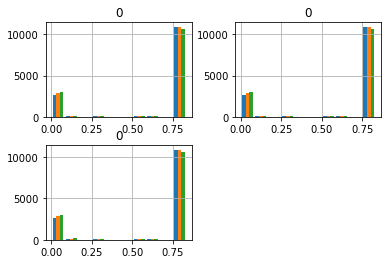

In [232]:
# 次级学习器的训练集的可视化结果
STK_test.hist()

In [233]:
from sklearn.linear_model import LogisticRegression as LR
lr = LR(random_state=9).fit(STK_train, train_data_dropna['loan_status'])
preds = lr.predict(STK_test)
print(accuracy_score(test_data_dropna['loan_status'], preds))

0.9040454222853087


- 结果未能比过baseline
- 将原始特征和新特征放在一起，作为训练集，喂入次级学习器，得到预测结果

In [245]:
STK_train2, STK_test2 = STK_train.copy(), STK_test.copy()
train_data_dropna.reset_index(inplace=True)
test_data_dropna.reset_index(inplace=True)
STK_train2 = pd.concat([STK_train2, train_data_dropna.drop(columns = 'loan_status')], axis = 1)
STK_test2 = pd.concat([STK_test2, test_data_dropna.drop(columns = 'loan_status')], axis = 1)

In [253]:
lr = LR(random_state=9).fit(STK_train2, train_data_dropna['loan_status'])
preds = lr.predict(STK_test2)
print(accuracy_score(test_data_dropna['loan_status'], preds))

0.8958126330731014


/home/jyy/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [297]:
from sklearn.manifold import TSNE
test_embedded = TSNE(3).fit_transform(test_data_dropna.drop(columns='loan_status'))
train_embedded = TSNE(3).fit_transform(train_data_dropna.drop(columns='loan_status'))

- 结果有明显下滑，可见受到过拟合影响
- 将TSNE降维后的结果，和初级学习器预测的结果放在一起，作为训练集，喂入次级学习器，得到预测结果

In [297]:
from sklearn.manifold import TSNE
test_embedded = TSNE(3).fit_transform(test_data_dropna.drop(columns='loan_status'))
train_embedded = TSNE(3).fit_transform(train_data_dropna.drop(columns='loan_status'))

In [298]:
STK_train3, STK_test3 = STK_train.copy(), STK_test.copy()

train_embedded = pd.DataFrame(train_embedded)
test_embedded = pd.DataFrame(test_embedded)

train_embedded.reset_index(inplace=False)
test_embedded.reset_index(inplace=False)

STK_train3 = pd.concat([STK_train3, train_embedded], axis = 1)
STK_test3 = pd.concat([STK_test3, test_embedded], axis = 1)

In [308]:
lr = LR(random_state=9).fit(STK_train3, train_data_dropna['loan_status'])
preds = lr.predict(STK_test3)
print(accuracy_score(test_data_dropna['loan_status'], preds))

0.9036905606813342


### 本章小结
- 使用随即森林、GBDT、XGBoost调参后的模型作为基本模型，尝试构建集成学习模型
- 基本模型与baseline相比，仅XGBoost在调参后超过了baseline，其他均未超过
- 投票选举法得到的集成模型在准确率上并未超过baseline，思考原因为随即森林和GBDT的准确率较低，干扰了无论是hard voting还是soft voting时整体的准确率
- stacking集成学习得到的结果,包括基础版、基础特征+原始特征、基础特征+tSNE，准确率在0.90左右，并未超过baseline